In [4]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib 
matplotlib.rcParams['figure.figsize'] = [8., 8.]
matplotlib.rcParams['font.size'] = 16.
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint, solve_ivp
import scipy
from sympy import init_printing
init_printing(use_latex='mathjax')
import sympy as sp
from IPython.display import Markdown as md

# Direct Collocation

Direct collocation is a method for solving trajectory optimization problems of the form 
\begin{align}
&\min && J(x,u)\\
&\text{wrt} && u\\
&\text{subject to} && \dot{x} = f(x, u)
\end{align}

This notebook references [An Introduction to Trajectory Optimization: How to Do Your Own Direct Collocation](https://epubs.siam.org/doi/pdf/10.1137/16M1062569) and follows section 2 in performing trajectory optimization for the sliding mass problem.


---
## Sliding Mass
The dynamics of a unit sliding point mass with no friction are
$$
\dot{x} = v \\
\dot{v} = u
$$
where $x$ is the position of the mass, $v$ is its velocity, and $u$ is the force applied to the block.

In [5]:
def f(y):
    """
    y: [x, v, u]
    x: position
    v: velocity 
    u: single element vector containing applied force 
    """
    x = y.item(0)
    v = y.item(1)
    u = y.item(2)
    return np.array([v, u])

### Initial and Final Conditions
We desire the mass to slide from 
\begin{align}
x(0) = 0 && x(1) = 1 \\
v(0) = 0 && v(1) = 0
\end{align}

This also defines the timescale of the system. To initialize each knot point, we start with the assumption that the position of the block transitions linearly between the initial and final positions and then use the dynamics to find the related initial trajectory for $v$ and $u$:
\begin{align}
&x_{init}(t) = t \\
&v_{init}(t) = \frac{d}{dt} x_{init} = 1 \\
&u_{init}(t) = \frac{d}{dt} v_{init} = 0
\end{align}

In [6]:
x0 = np.array([0., 0.]) # initial state
xf = np.array([1., 0.]) # desired final state

t0 = 0.
tf = 1.

N = 100 # number of knot points (in time)
hk = (tf - t0)/N # timestep between knot points
t = np.linspace(t0, tf, N)
# initial conditions
# x = t, v = dx/dt = 1, u = dv/dt = 0
# y_vec = [[i, 1., 0.] for i in np.linspace(t0, tf, N)]
y_vec = np.column_stack((t, 1.*t**0, 0.*t))
y_vec = np.reshape(y_vec,(-1)) # make y_vec 1D

### Objective Function
The objective we want to minimize is 
$$
\int_0^1 u^2(\tau) d\tau.
$$
This can be approximated as a sum using trapezoidal quadrature
$$
\int_0^1 u^2(\tau) d\tau \approx \sum_{k=0}^{N-1} \frac12 h_k (u_k^2 + u_{k+1}^2)
$$
where $u_k$ is the $t^{th}$ knot point of $u$ and $h_k$ is the time between knot points.

In [7]:
def obj(y):
    """
    The objective function to be minimized
    """
    y = np.reshape(y, (-1,3)) # return to [[x,v,u],...,[x,v,u]]
    u = y[:,2]
    w = np.ones(u.shape)
    w[1:-1] += 1. # w = [1 2 2 ... 2 1]
    J = np.sum(.5*hk*(u**2)*w)
    return J

### Constraints
There are two constraints to this problem:
1. The boundary constraints:
\begin{align}
x(0) = 0 && x(1) = 1 \\
v(0) = 0 && v(1) = 0
\end{align}
2. The collocation or dynamic constraints:
\begin{align}
\dot{x} &= f(x, u) \\
x_{k+1} - x_k &\approx \frac12 h_k (f_{k+1} + f_k)
\end{align}

In [8]:
def boundcons(y):
    """ Equality constraints """
    y = np.reshape(y, (-1,3))
    consvec = []
    consvec.append(y[0,0]  - x0[0]) # x(0) = 0
    consvec.append(y[0,1]  - x0[1]) # v(0) = 0
    consvec.append(y[-1,0] - xf[0]) # x(1) = 1
    consvec.append(y[-1,1] - xf[1]) # v(1) = 0
    return np.array(consvec)

def dyncons(y):
    """ Equality Constraints """
    y = np.reshape(y, (-1,3))
    consvec = []
    fk = f(y[0,:])
    for k in range(1, t.shape[0]):
        fkp1 = f(y[k,:])
        kcon = y[k,:2] - y[k-1,:2] - .5*hk*(fkp1+fk)
        consvec.append([kcon])
    return np.reshape(np.array(consvec), -1) # return as 1D array

# print(dyncons(y_vec))
# print(boundcons(y_vec))

### Solve!
Everything is now ready to solve the optimization problem

Success: True
Optimal objective value: 192.1901649459982


Text(0, 0.5, 'u')

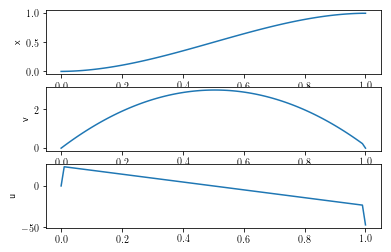

In [9]:
# import pdb; pdb.set_trace()
ret = scipy.optimize.minimize(
        obj,
        y_vec,
        method='SLSQP',
        constraints=[
            {'type':'eq', 'fun':boundcons},
            {'type':'eq', 'fun':dyncons}
        ])
print("Success:", ret.success)
print("Optimal objective value:", ret.fun)
y_opt = np.reshape(ret.x, (-1, 3))

fig, ax = plt.subplots(3,1)
ax[0].plot(t, y_opt[:,0])
ax[0].set_ylabel('x')

ax[1].plot(t, y_opt[:,1])
ax[1].set_ylabel('v')

ax[2].plot(t, y_opt[:,2])
ax[2].set_ylabel('u')

## Free Final Time
It may be desireable to leave $T_f$ free to allow the optimization more flexibility in acheiving the objective function.
To do so, we simply augment our vector of design variables $y$ to include $T_f$. Then, we recompute the value of $h_k$ each time a function which uses it is called.

Below, we modify the objective and the constraints to allow $T_f$ to vary.

We create a new objective function to minimize, which is $J = T_f$. This produces the "minimum time" solution to this problem. 

In [17]:
x0 = np.array([0., 0.]) # initial state
xf = np.array([1., 0.]) # desired final state

t0 = 0.
tf = 1.

N = 100 # number of knot points (in time)
hk = (tf - t0)/N # timestep between knot points
t = np.linspace(t0, tf, N)
# initial conditions
# x = t, v = dx/dt = 1, u = dv/dt = 0
# y_vec = [[i, 1., 0.] for i in np.linspace(t0, tf, N)]
y_vec = np.column_stack((t, 1.*t**0, 0.*t))
y_vec = np.reshape(y_vec,(-1)) # make y_vec 1D
y_vec = np.append(y_vec, [1.]) # tf = 1 as initial condition

In [19]:
def obj(y):
    """
    The objective function to be minimized
    """
    tf = y[-1] # last design variable is the final time
#     hk = (tf - t0)/N # timestep between knot points
#     y = np.reshape(y[:-1], (-1,3)) # return to [[x,v,u],...,[x,v,u]]
#     u = y[:,2]
#     w = np.ones(u.shape)
#     w[1:-1] += 1. # w = [1 2 2 ... 2 1]
#     J = np.sum(.5*hk*(u**2)*w)
    return tf

In [15]:
def boundcons(y):
    """ Equality constraints """
    tf = y[-1] # last design variable is the final time
    y = np.reshape(y[:-1], (-1,3))
    consvec = []
    consvec.append(y[0,0]  - x0[0]) # x(0) = 0
    consvec.append(y[0,1]  - x0[1]) # v(0) = 0
    consvec.append(y[-1,0] - xf[0]) # x(1) = 1
    consvec.append(y[-1,1] - xf[1]) # v(1) = 0
    return np.array(consvec)

def dyncons(y):
    """ Equality Constraints """
    tf = y[-1] # last design variable is the final time
    hk = (tf - t0)/N # timestep between knot points
    y = np.reshape(y[:-1], (-1,3))
    consvec = []
    fk = f(y[0,:])
    for k in range(1, t.shape[0]):
        fkp1 = f(y[k,:])
        kcon = y[k,:2] - y[k-1,:2] - .5*hk*(fkp1+fk)
        consvec.append([kcon])
    return np.reshape(np.array(consvec), -1) # return as 1D array

def timecon(y):
    """ Inequality bound constraint - final time must be positive"""
    return y[-1]


Success: True
Optimal objective value: 0.0493507139979609
Optimal time:  0.0493507139979609


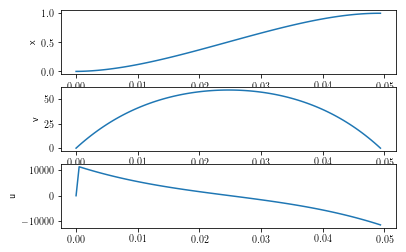

In [21]:
# import pdb; pdb.set_trace()
ret = scipy.optimize.minimize(
        obj,
        y_vec,
        method='SLSQP',
        constraints=[
            {'type':'eq', 'fun':boundcons},
            {'type':'eq', 'fun':dyncons},
            {'type':'ineq', 'fun':timecon}
        ])
print("Success:", ret.success)
print("Optimal objective value:", ret.fun)
tf_opt = ret.x[-1]
y_opt = np.reshape(ret.x[:-1], (-1, 3))
print("Optimal time: ", tf_opt)

t = np.linspace(t0, tf_opt, N)
fig, ax = plt.subplots(3,1)
ax[0].plot(t, y_opt[:,0])
ax[0].set_ylabel('x')

ax[1].plot(t, y_opt[:,1])
ax[1].set_ylabel('v')

ax[2].plot(t, y_opt[:,2])
ax[2].set_ylabel('u')
pass

This shows how the optimal time trajectory produces extremely large control inputs. This becomes a tradeoff between minimizing time and minimizing control effort.

### Interpolation
It turns out that when using trapezoidal collocation, the control $u$ is represented as a linear spline and the state trajectory is represented by a quadratic spline. That is, with $t \in [t_k, t_{k+1}]$, $\tau = t - t_k$, and $h_k = t_{k+1} - t_k$,
\begin{align}
u(t) &= u_k + \frac{\tau}{h_k}(u_{k+1} - u_k)\\
x(t) &= x_k + (\tau)f_k + \frac{\tau^2}{2 h_k} (f_{k+1} - f_k)
\end{align}